In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import imageio
import numpy as np
import cv2 as cv2
from skimage.color import rgb2gray,gray2rgb
import pickle,bz2

%matplotlib inline

#### Se descargan los pesos pre-entrenados del modelo Alexnet para hacer transfer learning

In [4]:
!wget -nc https://www.dropbox.com/s/885p0hqo28fny57/data.zip?dl=0

--2019-04-21 23:26:33--  https://www.dropbox.com/s/885p0hqo28fny57/data.zip?dl=0
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Conectando con www.dropbox.com (www.dropbox.com)[162.125.5.1]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/885p0hqo28fny57/data.zip [siguiente]
--2019-04-21 23:26:34--  https://www.dropbox.com/s/raw/885p0hqo28fny57/data.zip
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc267852de27d1e428877bbe41fe.dl.dropboxusercontent.com/cd/0/inline/Afe_RAOJZqAzXwThhMa9wRRw3yzGLsoZEiuZUvnOaUc_S9mf9cph1oaKn2W7XGHnBRmY8YkOaY6JVpiYpmqHpENzeOnswMXyrbA2nYpadFz4Aw/file# [siguiente]
--2019-04-21 23:26:34--  https://uc267852de27d1e428877bbe41fe.dl.dropboxusercontent.com/cd/0/inline/Afe_RAOJZqAzXwThhMa9wRRw3yzGLsoZEiuZUvnOaUc_S9mf9cph1oaKn2W7XGHnBRmY8YkOaY6JVpiYpmqHpENzeOnswMXyrbA2nYpadFz4Aw/file
Resolviendo

In [5]:
!unzip data.zip?dl=0

Archive:  data.zip?dl=0
   creating: data/
  inflating: data/.directory         
  inflating: data/KO_2006-01-01_to_2018-01-01.csv  
  inflating: data/Sentiment.csv      
  inflating: data/alexnet_conv1_conv2.pklz  
  inflating: data/international-airline-passengers.csv  
  inflating: data/mnist1.5k.csv.gz   
  inflating: data/pollution.csv      
  inflating: data/raw.csv            


In [6]:
!ls -lash data/alexnet_conv1_conv2.pklz

1,4M -rw-r--r-- 1 gabriel24 gabriel24 1,4M mar 26 15:18 data/alexnet_conv1_conv2.pklz


#### Se cargan los pesos de las primeras dos capas convolucionales del modelo alexnet

In [7]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"))
for k,(w,b) in alex_c12.iteritems():
    print k, b.shape, w.shape

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)


#### Se redimensionan las imágenes y se ajustan a la entrada de la red en este caso 128x128

In [8]:
train = []
test = []
i=0
for filename in glob.glob('chest_xray/train/NORMAL/*.jpeg'):     
    im=imageio.imread(filename)
    im=cv2.resize(im,(128,128))
    im=gray2rgb(im)
    train.append((im,0))
for filename in glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(128,128))
    im=gray2rgb(im)
    train.append((im,1))
for filename in glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(128,128))
    im=gray2rgb(im)
    test.append((im,1))
for filename in glob.glob('chest_xray/test/NORMAL/*.jpeg'): 
    im=imageio.imread(filename)
    im=cv2.resize(im,(128,128))
    im=gray2rgb(im)
    test.append((im,0))

In [9]:
TRAIN=pd.DataFrame(train,columns=['rX','label'],index= None)
TRAIN=TRAIN.sample(frac=1)
TEST=pd.DataFrame(test,columns=['rX','label'],index= None)
TEST=TEST.sample(frac=1)

/home/gabriel24/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 1000 + 1) instead
  after removing the cwd from sys.path.


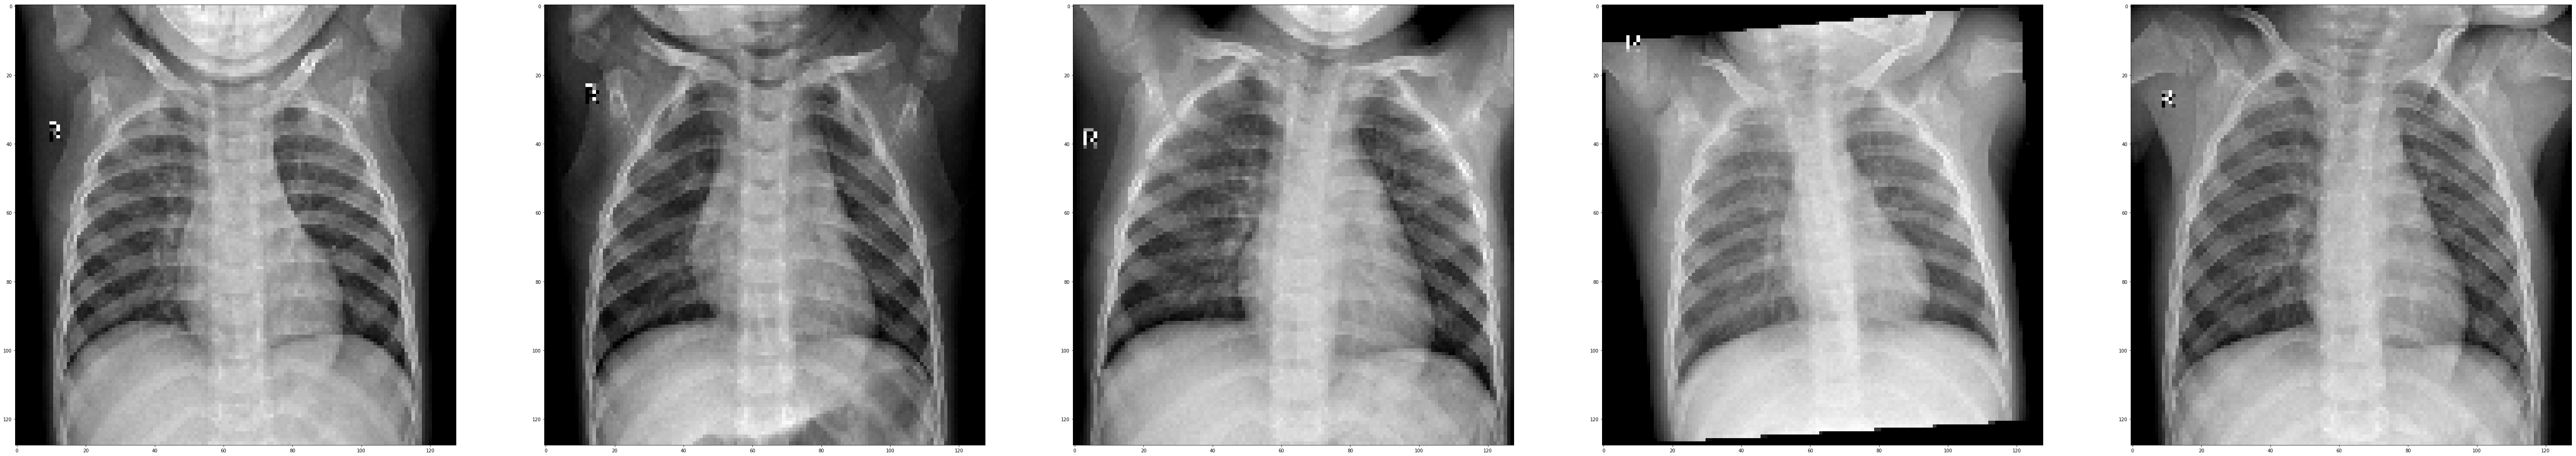

In [10]:
plt.figure(figsize=(100,40))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(TRAIN['rX'][np.random.random_integers(1000)],cmap="gray")
   

In [11]:
x_train=np.stack(TRAIN['rX'],axis=0)
y_train=np.stack(TRAIN['label'],axis=0)
x_test=np.stack(TEST['rX'],axis=0)
y_test=np.stack(TEST['label'],axis=0)

In [12]:
x_train.shape

(5216, 128, 128, 3)

#### Se define un modelo con dos primeras capas con la misma arquitectuta el modelo Alexnet y una capa densa de 16 neuronas

In [13]:
def get_model(num_classes, img_size=128, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [14]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [15]:
num_classes = 2
model = get_model(num_classes)


('using', 2, 'classes')
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
w = model.get_weights()
for i in w:
    print i.shape

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(144060, 16)
(16,)
(16, 2)
(2,)


#### Se hace transfer learning

In [17]:
alex_w1 = alex_c12["conv1"][0]
alex_w2 = alex_c12["conv1"][1]
w[0] = alex_w1
w[1] = alex_w2
model.set_weights(w)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 60)        697020    
_________________________________________________________________
flatten (Flatten)            (None, 144060)            0         
_________________________________________________________________
dropout (Dropout)            (None, 144060)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2304976   
__________

#### Se realiza un entrenamiento con una época solamente, como prueba, debido a que cuando se tenían más el kernel no respondía

In [15]:
train(model, batch_size=10, epochs=1)

Train on 5216 samples, validate on 624 samples
Epoch 1/1
624/624 [==============================] - 32s 51ms/step


{'acc': 0.625, 'loss': 6.044285872043708}

#### Se realiza un segundo entrenamiento con 2 épocas, donde se puede evidenciar que no hay una diferencia con respecto al entrenamiento con una época

In [25]:
train(model, batch_size=10, epochs=2)

Train on 5216 samples, validate on 624 samples
Epoch 1/2
5216/5216 [==============================] - 815s 156ms/step - loss: 4.3982 - acc: 0.7245 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 2/2
624/624 [==============================] - 31s 50ms/step


{'acc': 0.625, 'loss': 6.044285810910738}

####  De esta arquitectura se puede observar que no se alcanza un buen nivel de exactitud durante el entrenamiento del mismo y la función de pérdida no tiene la caída esperada, por lo tanto se concluye que le falta robustes o complejidad para llevar a cabo la tarea propuesta

In [ ]:
train(model, batch_size=10, epochs=5)

Train on 5216 samples, validate on 624 samples
Epoch 1/5
4460/5216 [========================>.....] - ETA: 3:58 - loss: 9.3308 - acc: 0.4209